In this notebook I estimate the Sequence Dissimilarity Index (essentially a TRB-only version of TCRdiv from Dash et al. 2017) and the performance of RBM at discriminating specific from unspecific TCR clones for antigen-specific T-cell repertoires from Balachandran et al. Nature 2017, Dash et al. Nature 2017, Glanville et al. Nature 2017. The related figure is Fig. 7.

In [1]:
rootf = FOLDER ## place here the folder where you save all the folders of the git ##

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = ['Garuda']
mpl.rcParams['font.serif'] = ['Garuda-Oblique']
import csv
from scipy.stats import pearsonr
from sklearn import metrics

curr_float = np.float32
curr_int = np.int16

def convert_number(seqs): # convert to numbers already aligned seqs
    aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V',  'W', 'Y','-']
    aadict = {aa[k]: k for k in range(len(aa))}
    msa_num = np.array(list(map(lambda x: [aadict[y] for y in x], seqs[0:])), dtype=curr_int, order="c")
    
    return msa_num

def convert_letter(seqs_n): # convert to numbers already aligned seqs
    aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V',  'W', 'Y','-']
    aadictinv = {k: aa[k] for k in range(len(aa))} 
    seqs=[]
    if type(seqs_n[0]) == curr_int:
        seqs.append(''.join([aadictinv[e] for e in seqs_n]))
    else:
        for t in range(len(seqs_n)):
            seqs.append(''.join([aadictinv[e] for e in seqs_n[t]]))
    return seqs

def uniqueIndexes(l):
    seen = set()
    res = []
    for i, n in enumerate(l):
        if n not in seen:
            res.append(i)
            seen.add(n)
    return res

#%matplotlib inline
import sys, os, pickle
sys.path.append(rootf + '/PGM/source/')
sys.path.append(rootf + '/PGM/utilities/')
sys.path.append(rootf + '/Align_utils/')
#from common_imports import set_num_threads
#set_num_threads(1) # Set the number of cores. Must be executed before importing numpy&numba.
import rbm,utilities
import Proteins_utils, RBM_utils, utilities, sequence_logo, plots_utils
import editdistance
from math import log, exp
import random

listpep1 = ['WT', 'NA', 'MUC16ID', 'MUC16WT', 'CR'];
listpep2 = ['WT', 'NA', 'MUC16ID', 'MUC16WT', 'CR'];
listpep3 = ['NA', 'CR'];
listpep4 = ['WT', 'NA', 'CR'];
listpep5 = ['NA', 'CR'];
listpep6 = ['NA1', 'NA2', 'CR1', 'CR2'];
listpep7 = ['NA','CR']; 
listpep=[listpep1,listpep2,listpep3,listpep4,listpep5,listpep6,listpep7];

/usr/local/lib/python3.9/dist-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/home/barbara/rbm_tcell/PGM/source/numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
/home/barbara/rbm_tcell/PGM/source/numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights


Calculate the CDR3-only version of TCRdiv for: PBMC data stimulated in vitro from Balachandran et al. 2017 (taking only expanded TRB clones according to Fisher's Exact Test - FET); Tetramer-sorted data from Dash et al. 2017 and Glanville et al. 2017.

In [2]:
## PBMC data stimulated in vitro from Balachandran et al 2017 (expanded only) ##

name_excel = 'summary_dissimilarity_auc'

listpep1 = ['WT', 'NA', 'MUC16ID', 'MUC16WT', 'CR'];
listpep2 = ['WT', 'NA', 'MUC16ID', 'MUC16WT', 'CR'];
listpep3 = ['NA', 'CR'];
listpep4 = ['WT', 'NA', 'CR'];
listpep5 = ['NA', 'CR'];
listpep6 = ['NA1', 'NA2', 'CR1', 'CR2'];
listpep7 = ['NA','CR']; 
listpep=[listpep1,listpep2,listpep3,listpep4,listpep5,listpep6,listpep7];

writer = pd.ExcelWriter(rootf + '/Data/' + name_excel + '.xlsx', engine = 'xlsxwriter')
name_tech = 'Sequence Dissimilarity Index'

dist_sdev = 5.7
distances = []
TCRdiv = []
av_div = []
len_exp = []
all_exp=[]
list_dev=[]
list_labels = []
all_expanded_len = []
all_expanded = []

for pp in range(1,8):
    for r in range(len(listpep[pp-1])):
        
        pep=listpep[pp-1][r]   
        ptn = pp
        summary1 = pd.read_csv(rootf + '/Data/summary_pt'+str(ptn)+'_'+ pep +'.tsv', sep='\t', low_memory=False)
        seqs = list(summary1['CDR3'])
        subset = uniqueIndexes(seqs)
        summary=summary1.loc[subset,:]
        seq = list(summary[summary['Exp. significant'] == 1]['CDR3'].values) ## this column tells whether the expansion is significant by FET
        all_expanded = all_expanded + seq
        Ntop=len(seq)
        all_expanded_len.append(Ntop)
        
        listsco=[]
        for r in range(Ntop):
            for s in range(r+1,Ntop):
                dis = editdistance.eval(seq[r], seq[s])
                listsco.append(dis)
                
        all_exp.append(listsco)       
        av_div.append(np.mean(listsco))
        
        overlap_sum = 0.0
        total_sum = 0.0
        for r in range(Ntop):
            for s in range(r+1,Ntop):
                dist = editdistance.eval(seq[r], seq[s])
                overlap_sum += exp(-1.0*(dist/dist_sdev)**2 )
                total_sum += 1.0

        if total_sum:
            p0 = overlap_sum / total_sum
            diversity = 1.0/p0
        else:
            p0 = 0.0
            diversity = 0.0

        distances.append(listsco)
        TCRdiv.append(diversity)
        list_labels.append('Pat_' + str(pp) + '_' + pep)
        len_exp.append(Ntop)

Max_L = np.max(all_expanded_len)

sheet_names = 'Balachandranetal2017'
datao = {'Samples': list_labels,
          name_tech: TCRdiv,
        'Size samples': all_expanded_len}

df = pd.DataFrame(datao, columns = ['Samples', name_tech, 'Size samples'])
df.to_excel(writer, sheet_name = sheet_names, index=0)

## Tetramer-sorted data from Dash et al. 2017 ##
filename = '/tcrb_aligned.txt'
path_o = rootf + '/Data/Dashetal2017'

seqs = []
with open(path_o+filename) as f:
    for line in f:
        linesplit = line.strip().split('\t')
        nogap1=linesplit[0].replace(' ','')
        seqs.append(nogap1)
        
seqs_dash = seqs

label = []
with open(path_o+ '/tcrb_label.txt') as f:
    for line in f:
        linesplit = line.strip().split('\t')
        nogap1=linesplit[1].replace(' ','')
        label.append(nogap1)

list_labels_dash = ['pp65$_{495}$','BLMF1$_{280}$','M1$_{58}$']

indM1 = []
indpp65 = []
indBMLF = []
for t in range(len(label)):
    if label[t] == 'M1':
        indM1.append(t)
    if label[t] == 'pp65':
        indpp65.append(t)
    if label[t] == 'BMLF':
        indBMLF.append(t)
        
indtot=[indpp65,indBMLF,indM1]
seqs_o=[]
for s in seqs:
    seqs_o.append(s.replace('-',''))

distances=[]
TCRdiv_dash=[]
all_len_dash = []
for inds in indtot:
    listsco=[]
    all_len_dash.append(len(inds))
    overlap_sum = 0.0
    total_sum = 0.0
    pp=[]
    for r in range(len(inds)):
        for s in range(r+1,len(inds)):
            if seqs_o[inds[r]] != seqs_o[inds[s]]: # remove duplicates at level of CDR3
                dist = editdistance.eval(seqs_o[inds[r]], seqs_o[inds[s]])
                listsco.append(dist)
                overlap_sum += exp(-1.0*(dist/dist_sdev)**2 )
                pp.append(exp(-1.0*(dist/dist_sdev)**2 ))
                total_sum += 1.0

    if total_sum:
        p0 = overlap_sum / total_sum
        diversity = 1.0/p0
    else:
        p0 = 0.0
        diversity = 0.0

    distances.append(listsco)
    TCRdiv_dash.append(diversity)
    
sheet_names = 'Dashetal2017'
datao = {'Samples': list_labels_dash,
          name_tech: TCRdiv_dash,
        'Size samples': all_len_dash}
df = pd.DataFrame(datao, columns = ['Samples', name_tech,'Size samples'])
df.to_excel(writer, sheet_name = sheet_names, index=0)
    
## Tetramer-sorted data from Glanville et al. 2017 ##

path_o = rootf + '/Data/Glanvilleetal2017'
filename = path_o + '/tcrb_label.txt'
labels=[]
with open(filename) as f:
    for line in f:
        linesplit = line.strip().split('\t')
        nogap2=linesplit[0].replace(' ','')
        labels.append(nogap2)
        
path_o = rootf + '/Data/Glanvilleetal2017'
filename = path_o + '/tcrb_aligned.txt'
seqs = []
with open(filename) as f:
    for line in f:
        linesplit = line.strip().split('\t')
        nogap1=linesplit[0].replace(' ','')
        seqs.append(nogap1)
    
list_labels_glanville = ['NP$_{44}$','M1$_{58}$','BLMF1$_{280}$','NP$_{177}$','pp65$_{495}$','pp65$_{417}$','pp50$_{245}$']

seqs_glanville = seqs
labels_u = list(np.unique(labels));
seqs_n = convert_number(seqs)
all_data = np.copy(seqs_n)
indtot = []
for ll in labels_u:
    ind_temp=[]
    for li in range(len(labels)):
        if labels[li] == ll:
            ind_temp.append(li)
    indtot.append(ind_temp)
indtot_glanville = indtot

seqs_o=[]
for s in seqs:
    seqs_o.append(s.replace('-',''))

distances=[]
TCRdiv_glanville=[]
all_len_glanville=[]
for inds in indtot:
    listsco=[]
    all_len_glanville.append(len(inds))
    overlap_sum = 0.0
    total_sum = 0.0
    pp=[]
    for r in range(len(inds)):
        for s in range(r+1,len(inds)):
            if seqs_o[inds[r]] != seqs_o[inds[s]]: # remove duplicates at level of CDR3
                dist = editdistance.eval(seqs_o[inds[r]], seqs_o[inds[s]])
                listsco.append(dist)
                overlap_sum += exp(-1.0*(dist/dist_sdev)**2 )
                pp.append(exp(-1.0*(dist/dist_sdev)**2 ))
                total_sum += 1.0

    if total_sum:
        p0 = overlap_sum / total_sum
        diversity = 1.0/p0
    else:
        p0 = 0.0
        diversity = 0.0

    distances.append(listsco)
    TCRdiv_glanville.append(diversity)
    
sheet_names = 'Glanvilleetal2017'
datao = {'Samples': list_labels_glanville,
        name_tech: TCRdiv_glanville,
        'Size samples': all_len_glanville}

df = pd.DataFrame(datao, columns = ['Samples', name_tech,'Size samples'])
df.to_excel(writer, sheet_name = sheet_names, index=0)

RBM model performance is estimated by a 5-fold leave-one-out validation protocol, here implemented.

In [4]:
listpep1 = ['WT', 'NA', 'MUC16ID', 'MUC16WT', 'CR'];
listpep2 = ['WT', 'NA', 'MUC16ID', 'MUC16WT', 'CR'];
listpep3 = ['NA', 'CR'];
listpep4 = ['WT', 'NA', 'CR'];
listpep5 = ['NA', 'CR'];
listpep6 = ['NA1', 'NA2', 'CR1', 'CR2'];
listpep7 = ['NA','CR']; 
listpep=[listpep1,listpep2,listpep3,listpep4,listpep5,listpep6,listpep7];

n_v = 19 # Number of visible units; = # sites in alignment.
n_h = 10 # Number of hidden units.
hu = n_h
visible = 'Potts' # Nature of visible units potential. Here, 'Potts' states are necessary for amino acids
n_cv = 21 # With n_cv = 21 colors (all possible amino acids + gap)
hidden = 'dReLU' # Nature of hidden units potential. Here, dReLU potential.
seed = 1 # Random seed (optional)
l12=0.1
l1b = l12
learning_rate = 0.1 # Initial learning rate (default: 0.1)
decay_after = 0.5 # Decay learning rate after 50% of iterations (default: 0.5)	
N_MC = 10 # Number of Monte Carlo steps between each update

maketraining = 0 ## By setting it to 1, new models are trained instead of using the ones already saved ##

FF=99
num_neg = Max_L*FF
neg_day0 = 1
list_pat=[]
list_pep=[]
AUC_all=[]
fold = 5

for pp in range(1,8):
    ptn=pp
    if neg_day0 == 1: ## Draw at random negative examples from the sample at day 0 of the other patients ##
        pep=listpep[pp-1][0]
        
        summary2 = pd.read_csv(rootf + '/Data/summary_pt'+str(ptn)+'_'+ pep +'.tsv', sep='\t', low_memory=False)
        for pep in listpep[pp-1][1:]:
            new = pd.read_csv(rootf + '/Data/summary_pt'+str(ptn)+'_'+ pep +'.tsv', sep='\t', low_memory=False)
            summary2=pd.concat([summary2,new])
        dd_day0 = list(np.unique(summary2['CDR3_gap'].values))
        
        file = rootf + '/Data/all_cdr3_aligned.txt' 

        neg_n = []
        with open(file) as f:
            for line in f:
                linesplit = line.strip().split('\t')
                nogap1=linesplit[0].replace(' ','')
                neg_n.append(nogap1)
        
        data_seqs_val_neg=[]
        for r in range(10*num_neg):
            rr=random.randint(0,len(neg_n)-1)
            if neg_n[rr] not in data_seqs_val_neg and neg_n[rr] not in all_expanded and neg_n[rr] not in dd_day0:
                   data_seqs_val_neg.append(neg_n[rr])
            if len(data_seqs_val_neg) >= num_neg:
                break
        
    for r in range(len(listpep[pp-1])):
        
        AUC=[]
        
        pep=listpep[pp-1][r]
        ptn = pp
        
        summary1 = pd.read_csv(rootf + '/Data/summary_pt'+str(ptn)+'_'+ pep +'.tsv', sep='\t', low_memory=False)
        seqs = list(summary1['CDR3'])
        subset = uniqueIndexes(seqs)
        summary=summary1.loc[subset,:]
        seqs_g = list(summary[summary['Exp. significant'] == 1]['CDR3_gap'].values)
        
        path_o = rootf + '/Models/CDR3out_pt' + str(ptn) + '_' + pep + '_L1O'
        full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))
        
        ff=0
        for t in range(fold):

            ind0 = 0 + t*int(len(seqs_g)/fold)
            ind1 = int(len(seqs_g)/fold) + t*int(len(seqs_g)/fold) 
            len_val = len(full_intR[ind0:ind1])

            data_seqs_training=[]
            for u in (full_intR[:ind0] + full_intR[ind1:]):
                data_seqs_training.append(seqs_g[u]) 
                
            data_seqs_val=[]
            for u in full_intR[ind0:ind1]:
                data_seqs_val.append(seqs_g[u])
                    
            data_seqs_training_n = convert_number(data_seqs_training)
            data_seqs_val_n = convert_number(data_seqs_val)
    
            if maketraining:
                seq_train_n = np.copy(data_seqs_training_n)
                B = len(seq_train_n)
                Meff = B
                print(Meff)
                l2f = 1/Meff
                batch_size = 32 # Size of mini-batches (and number of Markov chains used). Default: 100.
                n_updates = int(2e4)
                n_iter = (n_updates // (B // batch_size))
                RBM = rbm.RBM(visible = visible,hidden = hidden,n_v = n_v,n_h = n_h, n_cv = n_cv, random_state = seed, zero_field = False)
                RBM.fit(seq_train_n, weights=None, batch_size = batch_size,n_iter = n_iter, l1b = l1b, l2_fields = l2f, N_MC = N_MC, decay_after = decay_after, verbose = 0)
                namew = path_o + '/model_' + str(hu) + '_' + str(l12) + '_' + str(t) + '_expN.data'
                RBM_utils.saveRBM(namew, RBM)
                
            else:
                namew = path_o + '/model_' + str(hu) + '_' + str(l12) + '_' + str(t) + '_expN.data'
                RBM = RBM_utils.loadRBM(namew)
                
            ## Evaluate models on positive and negative ##
            
            data_seqs_val_neg_n = convert_number(data_seqs_val_neg[:len_val*FF])
            
            ll_val = RBM.likelihood(np.vstack((data_seqs_val_n, data_seqs_val_neg_n)))
        
            labels = np.hstack((np.ones(len_val), np.zeros(len_val*FF))) 
            scores = np.hstack((ll_val[:len_val], ll_val[len_val:]))
            fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
            
            AUC.append(metrics.auc(fpr, tpr))
        
        list_pat.append(ptn)
        list_pep.append(pep)
        AUC_all.append(np.mean(AUC))

sheet_names = 'AUC_Balachandranetal2017'
datao = {'Samples': list_labels,
          'AUROC': AUC_all}
df = pd.DataFrame(datao, columns = ['Samples', 'AUROC'])
df.to_excel(writer, sheet_name = sheet_names, index=0)

/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/1052694855.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_expNn.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


In [5]:
## Here Dash et al. 2017, for which we consider only the M1-specific repertoire (>100 seqs) ##
min_L = 100 # select samples with > 100 sequences
ind_sD = [ll for ll in range(len(all_len_dash)) if all_len_dash[ll] > min_L]
ind_sG = [ll for ll in range(len(all_len_glanville)) if all_len_glanville[ll] > min_L]

seqs_g = [seqs_dash[t] for t in indM1]
fold = 5                
path_o = rootf + '/Models/Dashetal2017'
full_intR = list((np.loadtxt(path_o + '/full_intR_exp.txt')).astype(np.int))

maketraining = 0
hu=10
l12=0.1
AUC_dash=[]
for t in range(fold):

    ind0 = 0 + t*int(len(seqs_g)/fold)
    ind1 = int(len(seqs_g)/fold) + t*int(len(seqs_g)/fold) 
    len_val = len(full_intR[ind0:ind1])

    data_seqs_training=[]
    for u in (full_intR[:ind0] + full_intR[ind1:]):
        data_seqs_training.append(seqs_g[u]) 

    data_seqs_val=[]
    for u in full_intR[ind0:ind1]:
        data_seqs_val.append(seqs_g[u])

    data_seqs_training_n = convert_number(data_seqs_training)
    data_seqs_val_n = convert_number(data_seqs_val)

    if maketraining:
        seq_train_n = np.copy(data_seqs_training_n)
        B = len(seq_train_n)
        Meff = B
        l2f = 1/Meff
        batch_size = 32 # Size of mini-batches (and number of Markov chains used). Default: 100.
        n_updates = int(2e4)
        n_iter = (n_updates // (B // batch_size))
        
        RBM = rbm.RBM(visible = visible,hidden = hidden,n_v = n_v,n_h = n_h, n_cv = n_cv, random_state = seed, zero_field = False)
        RBM.fit(seq_train_n, weights=None, batch_size = batch_size,n_iter = n_iter, l1b = l1b, l2_fields = l2f, N_MC = N_MC, decay_after = decay_after, verbose = 0)
        namew = path_o + '/model_' + str(hu) + '_' + str(l12) + '_' + str(t) + '_exp.data'
        RBM_utils.saveRBM(namew, RBM)

    else:
              
        namew = path_o + '/model_' + str(hu) + '_' + str(l12) + '_' + str(t) + '_exp.data'
        RBM = RBM_utils.loadRBM(namew)

    ## Evaluate models on positive and negative ##

    data_seqs_val_neg_n = convert_number(data_seqs_val_neg[:len_val*FF])

    ll_val = RBM.likelihood(np.vstack((data_seqs_val_n, data_seqs_val_neg_n)))
    
    if t == 3: # Save some positive/negative likelihoods
        lr=ll_val[len_val:]/np.log(10)
        lv=ll_val[:len_val]/np.log(10)

    labels = np.hstack((np.ones(len_val), np.zeros(len_val*FF))) 
    scores = np.hstack((ll_val[:len_val], ll_val[len_val:]))
    fpr, tpr, thresholds = metrics.roc_curve(labels, scores)

    AUC_dash.append(metrics.auc(fpr, tpr))
    

sheet_names = 'AUC_Dashetal2017'
datao = {'Samples': [list_labels_dash[ind_sD[0]]],
        'AUROC': [np.mean(AUC_dash)]}
df = pd.DataFrame(datao, columns = ['Samples', 'AUROC'])
df.to_excel(writer, sheet_name = sheet_names,index=0)
sheet_names = 'RBM_likelihood_Dashetal2017'
df0 = pd.DataFrame({'Lik. M1': lv}, columns = ['Lik. M1'])
df1 = pd.DataFrame({'Lik. control': lr}, columns = ['Lik. control'])

df = pd.concat([df0,df1], axis=1)
df.to_excel(writer, sheet_name = sheet_names, index=0)

/tmp/ipykernel_2440/3961708364.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_exp.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


In [6]:
## Here the epitope-specific repertoires from Glanville et al. 2017 ##

maketraining = 0
indtot = indtot_glanville
path_o = rootf + '/Models/Glanvilleetal2017'
AUC_glanville=[]
for indpep in ind_sG:
    seqs_g = [seqs_glanville[t] for t in indtot[indpep]]
 
    n_v = 19 # Number of visible units; = # sites in alignment.
    n_h = 10 # Number of hidden units.
    hu = n_h
    visible = 'Potts' # Nature of visible units potential. .
    n_cv = 21 # With n_cv = 21 colors (all possible amino acids + gap)
    hidden = 'dReLU' # Nature of hidden units potential. Here, dReLU potential.
    seed = 1 # Random seed (optional)
    l12=0.1
    l1b = l12
    fold = 5           
    full_intR = list((np.loadtxt(path_o + '/full_intR_exp' + str(indpep) + '.txt')).astype(np.int))
    AUC=[]
    for t in range(fold):

        ind0 = 0 + t*int(len(seqs_g)/fold)
        ind1 = int(len(seqs_g)/fold) + t*int(len(seqs_g)/fold) 
        len_val = len(full_intR[ind0:ind1])

        data_seqs_training=[]
        for u in (full_intR[:ind0] + full_intR[ind1:]):
            data_seqs_training.append(seqs_g[u]) 

        data_seqs_val=[]
        for u in full_intR[ind0:ind1]:
            data_seqs_val.append(seqs_g[u])

        data_seqs_training_n = convert_number(data_seqs_training)
        data_seqs_val_n = convert_number(data_seqs_val)

        if maketraining:
            seq_train_n = np.copy(data_seqs_training_n)
            B = len(seq_train_n)
            Meff = B
            l2f = 1/Meff
            batch_size = 32 # Size of mini-batches (and number of Markov chains used). Default: 100.
            n_updates = int(2e4)
            n_iter = (n_updates // (B // batch_size))          
            RBM = rbm.RBM(visible = visible,hidden = hidden,n_v = n_v,n_h = n_h, n_cv = n_cv, random_state = seed, zero_field = False)
            RBM.fit(seq_train_n, weights=None, batch_size = batch_size,n_iter = n_iter, l1b = l1b, l2_fields = l2f, N_MC = N_MC, decay_after = decay_after, verbose = 0)
            namew = path_o + '/model_' + str(hu) + '_' + str(l12) + '_' + str(t) + '_exp.data'
            RBM_utils.saveRBM(namew, RBM)
        else:
            namew = path_o + '/model_' + str(hu) + '_' + str(l12) + '_' + str(t) + '_exp.data'
            RBM = RBM_utils.loadRBM(namew)

        data_seqs_val_neg_n = convert_number(data_seqs_val_neg[:len_val*FF])
        ll_val = RBM.likelihood(np.vstack((data_seqs_val_n, data_seqs_val_neg_n)))
        labels = np.hstack((np.ones(len_val), np.zeros(len_val*FF))) 
        scores = np.hstack((ll_val[:len_val], ll_val[len_val:]))
        fpr, tpr, thresholds = metrics.roc_curve(labels, scores)

        AUC.append(metrics.auc(fpr, tpr))
    AUC_glanville.append(np.mean(AUC))

sheet_names = 'AUC_Glanvilleetal2017'

datao = {'Samples': [list_labels_glanville[i] for i in ind_sG],
          'AUROC': AUC_glanville}

df = pd.DataFrame(datao, columns = ['Samples', 'AUROC'])
df.to_excel(writer, sheet_name = sheet_names, index=0)
writer.save()

/tmp/ipykernel_2440/2155033321.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_exp' + str(indpep) + '.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/2155033321.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_exp' + str(indpep) + '.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/2155033321.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_exp' + str(indpep) + '.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/2155033321.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_exp' + str(indpep) + '.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


/tmp/ipykernel_2440/2155033321.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  full_intR = list((np.loadtxt(path_o + '/full_intR_exp' + str(indpep) + '.txt')).astype(np.int))


Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I
Mismatch dimensions (32, 10), [10, 10], reinitializating I
Mismatch dimensions (32, 19, 21), [10, 19, 21], reinitializating I


Use the results computed for the panels of Fig. 7

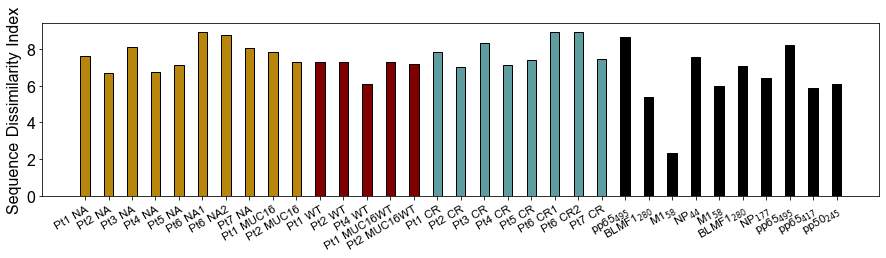

In [7]:
## Visualization ##

import pandas as pd  
name_excel = 'summary_dissimilarity_auc'
name_tech = 'Sequence Dissimilarity Index'
list_labels_dash = ['pp65$_{495}$','BLMF1$_{280}$','M1$_{58}$']
list_labels_glanville = ['NP$_{44}$','M1$_{58}$','BLMF1$_{280}$','NP$_{177}$','pp65$_{495}$','pp65$_{417}$','pp50$_{245}$']

sheet_names = 'Balachandranetal2017'
file = pd.read_excel(rootf + '/Data/' + name_excel + '.xlsx', sheet_name = sheet_names)
list_pat=[]
list_pep=[]
TCRdiv=[]
all_expanded_len=[]
for pp in range(1,8):
    for r in range(len(listpep[pp-1])):
        pep = listpep[pp-1][r]
        list_pat.append(pp)
        list_pep.append(pep)
        TCRdiv.append((file[file['Samples'] == 'Pat_' + str(pp) + '_' + pep][name_tech].values)[0])
        all_expanded_len.append((file[file['Samples'] == 'Pat_' + str(pp) + '_' + pep]['Size samples'].values)[0])

datao = {'Patient': list_pat,
        'Peptide': list_pep,
        name_tech: TCRdiv,
        }

df_div = pd.DataFrame (datao, columns = ['Patient','Peptide', name_tech])

list_NA = ['NA', 'NA1', 'NA2']
list_MUC16 = ['MUC16ID']
list_XRM = ['CR', 'CR1', 'CR2']
list_WT = ['WT']
list_MUC16WT = ['MUC16WT']

df = df_div
auroc_xrm = list(df[df['Peptide'].isin(list_XRM)][name_tech].values)
auroc_wt_muc = list(df[df['Peptide'].isin(list_WT)][name_tech].values) + list(df[df['Peptide'].isin(list_MUC16WT)][name_tech].values)
auroc_na_muc = list(df[df['Peptide'].isin(list_NA)][name_tech].values) + list(df[df['Peptide'].isin(list_MUC16)][name_tech].values)

names_na_muc=['Pt1 NA','Pt2 NA','Pt3 NA','Pt4 NA','Pt5 NA','Pt6 NA1', 'Pt6 NA2', 'Pt7 NA', 'Pt1 MUC16','Pt2 MUC16']
names_na = names_na_muc[:-2]
names_wt_muc=['Pt1 WT','Pt2 WT','Pt4 WT', 'Pt1 MUC16WT','Pt2 MUC16WT']
names_wt=names_wt_muc[:-2]
names_xrm=['Pt1 CR','Pt2 CR','Pt3 CR','Pt4 CR','Pt5 CR','Pt6 CR1', 'Pt6 CR2', 'Pt7 CR']

list_vir = list_labels_dash + list_labels_glanville

sheet_names = 'Dashetal2017'   
file = pd.read_excel(rootf + '/Data/' + name_excel + '.xlsx', sheet_name = sheet_names)
TCRdiv_dash = []
all_len_dash = []
for t in range(len(list_labels_dash)):
    TCRdiv_dash.append(file[file['Samples'] == list_labels_dash[t]][name_tech].values[0])
    all_len_dash.append(file[file['Samples'] == list_labels_dash[t]]['Size samples'].values[0])

sheet_names = 'Glanvilleetal2017'      
file = pd.read_excel(rootf + '/Data/' + name_excel + '.xlsx', sheet_name = sheet_names)
TCRdiv_glanville = []
all_len_glanville = []
for t in range(len(list_labels_glanville)):
    TCRdiv_glanville.append(file[file['Samples'] == list_labels_glanville[t]][name_tech].values[0])
    all_len_glanville.append(file[file['Samples'] == list_labels_glanville[t]]['Size samples'].values[0])
    
colors3 = list(np.repeat(['DarkGoldenRod'],len(names_na_muc))) + list(np.repeat(['Maroon'],len(names_wt_muc))) + list(np.repeat(['CadetBlue'],len(names_xrm)))+ list(np.repeat(['black'],len(list_vir)))
s2=15
sc=2
fig,ax=plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
fig.subplots_adjust(bottom = 0.4)
meth = names_na_muc + names_wt_muc + names_xrm + list_vir;
meth_val = np.array(auroc_na_muc + auroc_wt_muc + auroc_xrm + TCRdiv_dash+ TCRdiv_glanville) 
x_pos = np.arange(len(meth_val))
x_pos = np.arange(0,2*len(meth_val),2)
ax.bar(x_pos, meth_val, alpha=1, edgecolor='k', align = 'center', capsize=sc, color = colors3)
ax.set_xticks(x_pos)
s2=16
ax.set_ylabel(name_tech, fontsize = s2)
ax.tick_params(axis='y', which='major', labelsize = s2)
ax.set_xticklabels(meth, rotation = 30, fontsize = 11.5, ha='right', rotation_mode = 'anchor');

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


9


Text(0.685, 7, '|r| = 0.95')

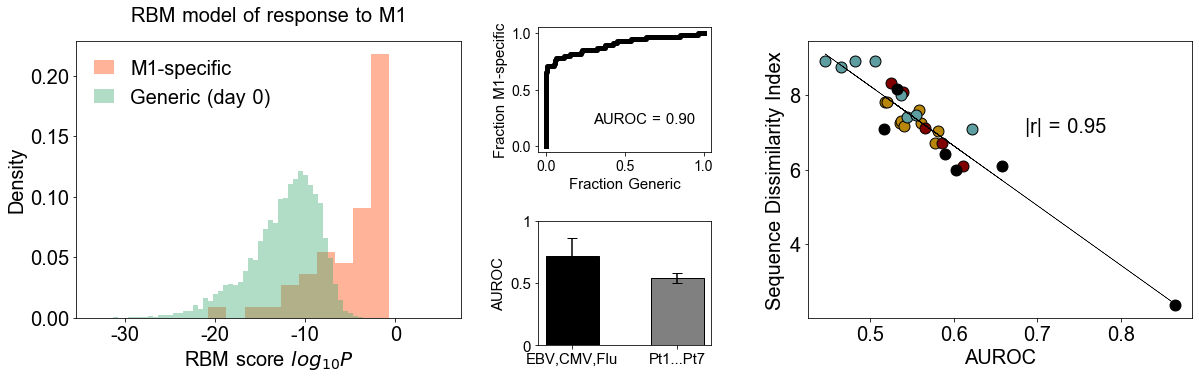

In [8]:
datao = {'Patient': list_pat,
        'Peptide': list_pep,
        'Size samples': all_expanded_len,
        }
df_len = pd.DataFrame (datao, columns = ['Patient','Peptide','Size samples'])

list_NA = ['NA', 'NA1', 'NA2']
list_MUC16 = ['MUC16ID']
list_XRM = ['CR', 'CR1', 'CR2']
list_WT = ['WT']
list_MUC16WT = ['MUC16WT']

df = df_len
auroc_xrm = list(df[df['Peptide'].isin(list_XRM)]['Size samples'].values)
auroc_wt_muc = list(df[df['Peptide'].isin(list_WT)]['Size samples'].values) + list(df[df['Peptide'].isin(list_MUC16WT)]['Size samples'].values)
auroc_na_muc = list(df[df['Peptide'].isin(list_NA)]['Size samples'].values) + list(df[df['Peptide'].isin(list_MUC16)]['Size samples'].values)
all_expanded_len_r = np.array(auroc_na_muc + auroc_wt_muc + auroc_xrm) 

min_L = 100 # select samples with > 100 sequences
ind_s = [ll for ll in range(len(all_expanded_len_r)) if all_expanded_len_r[ll] > min_L]
ind_sD = [ll for ll in range(len(all_len_dash)) if all_len_dash[ll] > min_L]
ind_sG = [ll for ll in range(len(all_len_glanville)) if all_len_glanville[ll] > min_L]

df = df_div
auroc_xrm = list(df[df['Peptide'].isin(list_XRM)][name_tech].values)
auroc_wt_muc = list(df[df['Peptide'].isin(list_WT)][name_tech].values) + list(df[df['Peptide'].isin(list_MUC16WT)][name_tech].values)
auroc_na_muc = list(df[df['Peptide'].isin(list_NA)][name_tech].values) + list(df[df['Peptide'].isin(list_MUC16)][name_tech].values)
TCRdiv_r = np.array(auroc_na_muc + auroc_wt_muc + auroc_xrm) 

dists_g = np.array([TCRdiv_glanville[i] for i in ind_sG])
dists_d = TCRdiv_dash[ind_sD[0]]

sheet_names = 'AUC_Balachandranetal2017'
file = pd.read_excel(rootf + '/Data/' + name_excel + '.xlsx', sheet_name = sheet_names)
list_pat=[]
list_pep=[]
AUC_all=[]
for pp in range(1,8):
    for r in range(len(listpep[pp-1])):
        pep = listpep[pp-1][r]
        list_pat.append(pp)
        list_pep.append(pep)
        AUC_all.append((file[file['Samples'] == 'Pat_' + str(pp) + '_' + pep]['AUROC'].values)[0])

datao = {'Patient': list_pat,
        'Peptide': list_pep,
        'AUROC': AUC_all,
        }

df_auc = pd.DataFrame (datao, columns = ['Patient','Peptide', 'AUROC'])

df = df_auc
auroc_xrm = list(df[df['Peptide'].isin(list_XRM)]['AUROC'].values)
auroc_wt_muc = list(df[df['Peptide'].isin(list_WT)]['AUROC'].values) + list(df[df['Peptide'].isin(list_MUC16WT)]['AUROC'].values)
auroc_na_muc = list(df[df['Peptide'].isin(list_NA)]['AUROC'].values) + list(df[df['Peptide'].isin(list_MUC16)]['AUROC'].values)
AUC_all_r = np.array(auroc_na_muc + auroc_wt_muc + auroc_xrm)

sheet_names = 'AUC_Dashetal2017'   
file = pd.read_excel(rootf + '/Data/' + name_excel + '.xlsx', sheet_name = sheet_names)
AUC_dash = file[file['Samples'] == list_labels_dash[ind_sD[0]]]['AUROC'].values[0]
    
sheet_names = 'AUC_Glanvilleetal2017'      
file = pd.read_excel(rootf + '/Data/' + name_excel + '.xlsx', sheet_name = sheet_names)
AUC_glanville = []
for t in ind_sG:
    AUC_glanville.append(file[file['Samples'] == list_labels_glanville[t]]['AUROC'].values[0])
    
sheet_names = 'RBM_likelihood_Dashetal2017'
file = pd.read_excel(rootf + '/Data/' + name_excel + '.xlsx', sheet_name = sheet_names)
lv0 = file['Lik. M1'].values
lv = lv0[~np.isnan(lv0)]
lr = file['Lik. control'].values
    
import seaborn as sns
mpl.rcParams["legend.handlelength"] = 1.0
s2 = 20 
s1 = 15
labels = np.hstack((np.ones((len(lv))), np.zeros((len(lr)))))
scores = np.hstack((lv, lr))
fpr, tpr, thresholds = metrics.roc_curve(labels, scores)

w=5
colors = ['r','orange', 'deepskyblue', 'blue', (100/255, 220/255, 0), 'forestgreen']

fig, axf = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(20)
fig.subplots_adjust(bottom = 0.4,hspace=0.2,wspace=0.9)

ax = axf[0]
w0=0
sns.distplot(lv, hist = True, kde_kws = {'linewidth': w0}, color = 'OrangeRed', label = 'M1-specific', ax = ax, bins=10)
sns.distplot(lr, hist = True, kde_kws = {'linewidth': w0}, color = (60/255, 170/255, 113/255), label = r'Generic (day 0)', ax = ax)
ax.set_title('RBM model of response to M1', fontsize=s2)
ax.set_xlabel(r'RBM score $log_{10} P$', fontsize=s2)
ax.set_ylabel('Density', fontsize=s2)
ax.legend(fontsize=s2, markerscale=3, frameon=False, loc='upper left')
ax.tick_params(axis = 'both', which = 'major', labelsize=s2)

## for inset ###
axin1 = ax.inset_axes([1.2, 0.6, 0.45, 0.45]) 
ax = axin1
ax.plot(fpr,tpr,lw=w,color='k')
NN=0
ax.set_xlabel('Fraction Generic', fontsize=s1+NN)
ax.set_ylabel('Fraction M1-specific', fontsize=s1+NN)
ax.tick_params(axis='both', which='major', labelsize=s1+NN-1)
ax.text(0.3, 0.2, 'AUROC = ' + format(metrics.auc(fpr, tpr), '.2f'), fontsize=s1+NN)

ax = axf[0]
axin1 = ax.inset_axes([1.2,-0.1, 0.45, 0.45]) 
ax = axin1
colors4=['Black','Gray']
meth = ['EBV,CMV,Flu', 'Pt1...Pt7']
aucT = np.hstack((np.mean(AUC_dash),np.mean(AUC_glanville)))
meth_val = np.hstack((np.mean(aucT),np.mean(AUC_all_r)))
x_pos = np.arange(len(meth_val))
nn=1
x_pos = np.arange(0,nn*len(meth_val),nn)
ax.bar(x_pos, meth_val, yerr=[np.std(aucT),np.std(AUC_all_r)], alpha=1, width = 0.5, edgecolor='k', align = 'center',capsize=5, color = colors4)
ax.set_xticks(x_pos)
ax.set_ylabel('AUROC', fontsize = s1)
ax.tick_params(axis='y', which='major', labelsize = s1)
ax.set_xticklabels(meth, rotation = 0, fontsize = s1, ha='center', rotation_mode = 'anchor')
ax.set_ylim([0,1])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])

ax = axf[1]

meth = names_na_muc + names_wt_muc + names_xrm + ['Tetramer']
ind_ss = ind_s + [-6,-5,-4,-3,-2,-1]
aucs = np.hstack((np.array(AUC_all), np.mean(AUC_dash), np.array(AUC_glanville)))
dists = np.hstack((np.array(TCRdiv), dists_d, dists_g))
sc = 120
ind_s = ind_ss
ax.scatter(aucs[ind_s[:9]],dists[ind_s[:9]], c = 'DarkGoldenRod', edgecolors='k', s = sc)
print(len(aucs[ind_s[:9]]))
ax.scatter(aucs[ind_s[9:14]], dists[ind_s[9:14]], c = 'Maroon', edgecolors='k', s = sc)
ax.scatter(aucs[ind_s[14:-6]], dists[ind_s[14:-6]], c = 'CadetBlue', edgecolors='k', s = sc)
ax.scatter(aucs[ind_s[-6:]], dists[ind_s[-6:]], c = 'k', edgecolors='k', s = sc)

m, b = np.polyfit(aucs[ind_s], dists[ind_s], 1)
ax.plot(aucs[ind_s], m*aucs[ind_s] + b, c = 'k', linewidth=0.5)
r=pearsonr(-aucs[ind_s], dists[ind_s])[0]
ax.set_xlabel('AUROC', fontsize = s2)
ax.set_ylabel(name_tech, fontsize = s2)
ax.tick_params(axis='both', which='major', labelsize = s2)
ax.text(0.685, 7, '|r| = ' + format(r, '.2f'), fontsize=s2)